In [1]:
import numpy as np
from numpy import save
from numpy import load
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import lava.lib.dl.slayer as slayer
from tqdm import tqdm
import os
from loss import DECOLLELoss
from assistant_fixed import HybridAssistant
from torch.nn.functional import one_hot

## Dataset creation 
### This makes and SAVES the dataset, we want to keep the SAME one across all our training

In [2]:
np.random.seed(0)

n_train = 5000 # 1,000,000 in the original paper
n_val = 1000 # 8192 in the original paper
n_prot = 20 # 200 prototypes in the original paper
n_class = 10 # 100 classes in the original paper 

layer_sizes = [50, 500, 50, 2500] # These are same as the original

n_ors = layer_sizes[0] # 50 olfactory receptors
n_timepoints = 150 # Number of timepoints per sample in the dataset
batch_size = 256

class ORDataset(Dataset):
    """Dataset operating on olfactory receptors"""

    def __init__(self, input, labels):
        """
        Arguments:
            dataset (np.ndarray): the olfactory receptor dataset, in the shape
                of (n_ors, n_timepoints, n_samples)
        """
        self.input = input
        self.labels = labels  

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (self.input[:,:,idx], self.labels[idx])


In [142]:
# Creating the dataset

# The "prototype smells" for each class; the prototype closest to the 
# smell in euclidean space determines the smell's class (BUT NOT DIRECTLY)
prototypes = np.random.uniform(0,1, (n_prot, n_ors)).astype(np.float32)

train_x = np.random.uniform(0,1, (n_train, n_ors)).astype(np.float32)
val_x = np.random.uniform(0,1, (n_val, n_ors)).astype(np.float32)

def get_labels(prototypes, odors):
    ''' The prototype with the shortest Euclidean distance to each smell
        becomes the smell's label'''
    # Calculating euclidean distances for each odor, across all prototypes
    dist = euclidean_distances(prototypes, odors)
    # Finding the prototype with the minimum distance to each smell, and partitioning
    # into the ACTUAL CLASS (just assume they're put next to each other)
    return np.argmin(dist, axis=0)//2

train_y = get_labels(prototypes, train_x).astype(np.int32)
val_y = get_labels(prototypes, val_x).astype(np.int32)

# Stacking the input to 300 timepoints
train_x = train_x.transpose()
val_x = val_x.transpose()
train_x = np.repeat(train_x[:, np.newaxis, :], n_timepoints, axis=1)
val_x = np.repeat(val_x[:, np.newaxis, :], n_timepoints, axis=1)
train_x = torch.tensor(train_x)
val_x = torch.tensor(val_x)

# Saving datasets 
data_folder = os.path.join(os.getcwd(),'Data')
os.makedirs(data_folder, exist_ok=True)

save(os.path.join(data_folder, 'train_x'), train_x)
save(os.path.join(data_folder, 'train_y'), train_y)
save(os.path.join(data_folder, 'val_x'), val_x)
save(os.path.join(data_folder, 'val_y'), val_y)

## Loading pre-saved dataset and putting into dataloader

In [3]:
data_folder = 'Data'
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Network definition + initialization

In [4]:
class HybridNetwork(torch.nn.Module):
    def __init__(self, layer_sizes, 
                 n_class, stdp_learning_rate, 
                 stdp_tau_combined, train_hybrid, burn_in=0):
        
        super(HybridNetwork, self).__init__()

        self.burn_in = burn_in
        self.stdp_learning_rate = stdp_learning_rate
        self.stdp_tau_combined = stdp_tau_combined
        self.layer_sizes = layer_sizes
        self.train_hybrid = train_hybrid

        # Input neuron parameters, threshold set to 1 as per course guidelines
        input_neuron_parameters = {
            'threshold': 1.,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        # Default values in SLAYER and DECOLLE notebooks
        neuron_parameters = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }

        # Defining layers. Input layer defined separately to make dataset work.
        blocks = [slayer.block.cuba.Dense(
            input_neuron_parameters, layer_sizes[0], layer_sizes[1], weight_norm=False)]
        
        for i in range(1, len(layer_sizes)-1):
            blocks.append(slayer.block.cuba.Dense(
                neuron_parameters, layer_sizes[i], 
                layer_sizes[i+1], weight_norm=False))
            
        self.blocks = torch.nn.ModuleList(blocks)

        # Removing gradient dependence for the STDP block if training in hybrid
        # mode. 
        if self.train_hybrid: 
            self.blocks[-1].synapse.weight.requires_grad=False 
            
        # Defining random readouts for each layer except the input. 
    
        readout_layers = []
        for layer_size in self.layer_sizes[1:]:
                readout_layers.append(torch.nn.Linear(layer_size, n_class, bias=False))
        self.readout_layers = torch.nn.ModuleList(readout_layers)

        # If training in hybrid mode, last readout layer needs gradient
        # computation, whereas none of the readouts need this with 
        # standard DECOLLE
        for readout_layer in self.readout_layers:
            readout_layer.weight.requires_grad = False
        if self.train_hybrid:
            self.readout_layers[-1].weight.requires_grad = True
    
    def forward(self, spike):
        # First we pass the input through all of the layers and get the
        # corresponding output at each layer, then we iterate through
        # these layers' linear readout layers as well. Readout layers
        # are returned for all layers, with the pre-specified gradient 
        # dependencies determining what happens when these readouts are used
        # for gradient descent. 
        
        spike.requires_grad_()
        all_spikes = [] # all spikes within the model
        readouts = []
        voltages = []
        spike_counts = []

        for i, layer in enumerate(self.blocks):
            # Getting voltage at each postsynaptic neuron corresponding to input
            z = layer.synapse(spike.detach())
            _, voltage = layer.neuron.dynamics(z)
            # Getting the spikes that result from the voltage at these neurons
            spike = layer.neuron.spike(voltage)

            # If training in hybrid mode, we don't want any gradient accumulation
            # for the spikes created within the last block
            if self.train_hybrid and i == 2:
                all_spikes.append(spike.detach())
            else:
                all_spikes.append(spike)

            voltages.append(voltage)
            spike_counts.append(torch.mean(spike.detach()))
        
        for readout_layer, spike in zip(self.readout_layers, all_spikes):
            # Getting a linear readout of the layer
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(readout_layer(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))
        
        return all_spikes, readouts, voltages, spike_counts
    
    def reset_(self):
        # Resetting the state of the network
        for layer in self.blocks:
            layer.neuron.current_state[:] = 0
            layer.neuron.voltage_state[:] = 0
    
    def init_state(self, inputs, burn_in=None):
        # Resets the network state, and applies an initial burn-in period
        # by passing the first few timepoints of the input through the network
        self.reset_()
        if burn_in is None:
            burn_in = self.burn_in
        self.forward(inputs[..., :burn_in])

        return inputs[..., :burn_in] 
    
    def plot_weights(self, block_idx):
        plt.figure()
        layer_params = self.blocks[block_idx].synapse.weight.data
        weight_matrix = np.squeeze(layer_params.numpy())
        plt.imshow(weight_matrix, aspect='auto')
        plt.colorbar(shrink = 0.8, label = 'Weight')
        plt.title(f'Weights for block {block_idx}')
        plt.xlabel('Presynaptic neurons')
        plt.ylabel('Postsynaptic neurons')
    
    def print_weights(self, block_idx):
        print(np.squeeze(self.blocks[block_idx].synapse.weight.data.numpy()))

    
# Initializing everything
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

stdp_learning_rate = 0.000007 
stdp_tau_combined = -2    

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=True, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

## Training + visualizations

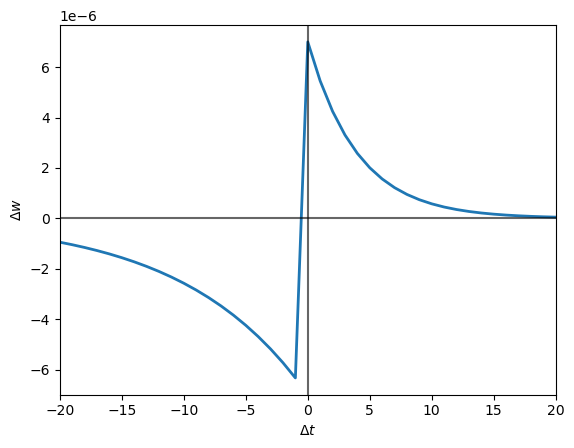

In [5]:
# Can visualize the function which the assistant will use. The parameters 
# stdp_learning_rate and stdp_tau_combined will influence this!
assistant.plot_stdp_curve()

## 1:1 ratio

In [6]:
layer_sizes = [50, 500, 50, 50] 

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=False, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

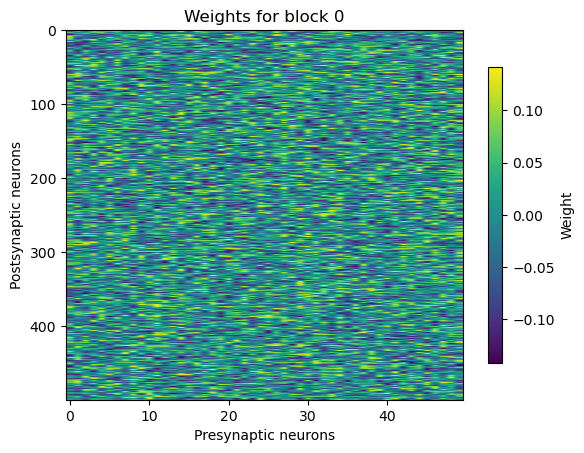

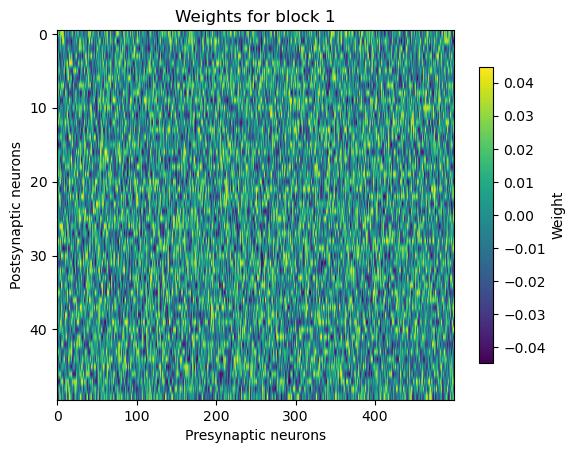

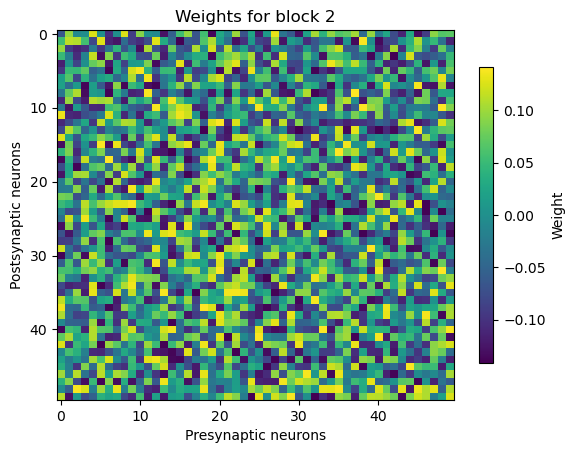

In [7]:
# Easy visualization of what's going on with the network weights.
# These are untrained!
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

In [ ]:
trained_folder = 'Trained/1_to_1'
os.makedirs(trained_folder, exist_ok=True)

epochs = 30
for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter): 
        output, count = assistant.train(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Testing
    test_iter = iter(testing_loader) 
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Saving network if best performance so far
    # if stats.testing.best_accuracy:
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_1to1_30epochs_epoch_{epoch_i}.pt')
    stats.update()
    stats.save(path= trained_folder+ "/")

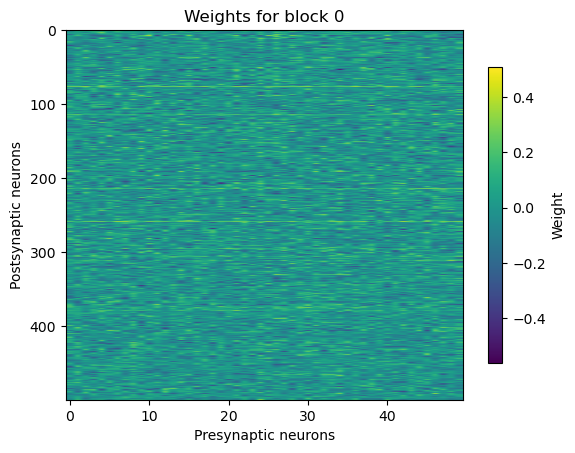

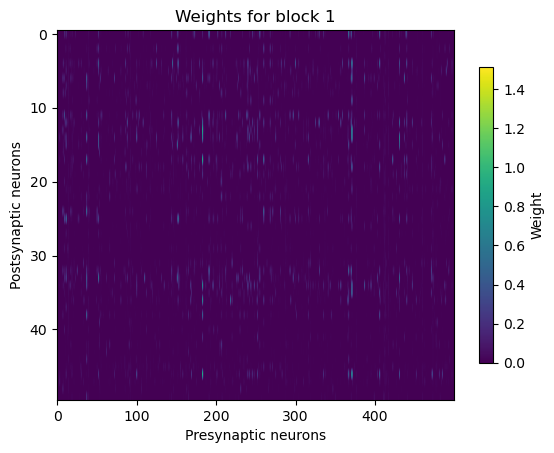

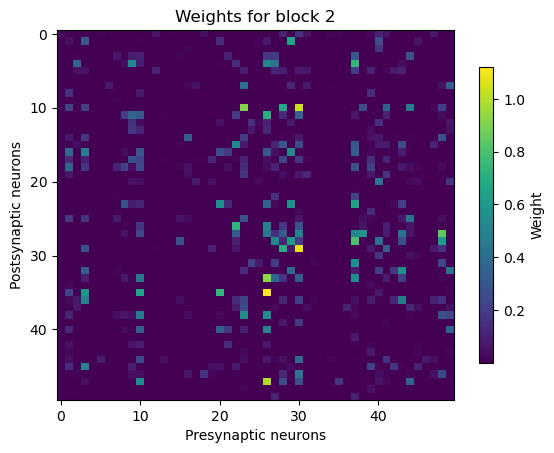

In [9]:
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

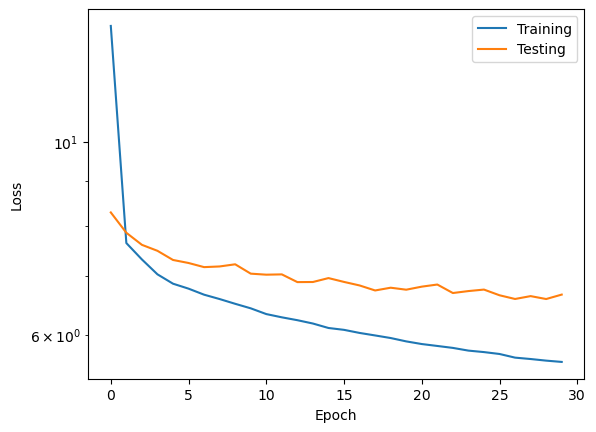

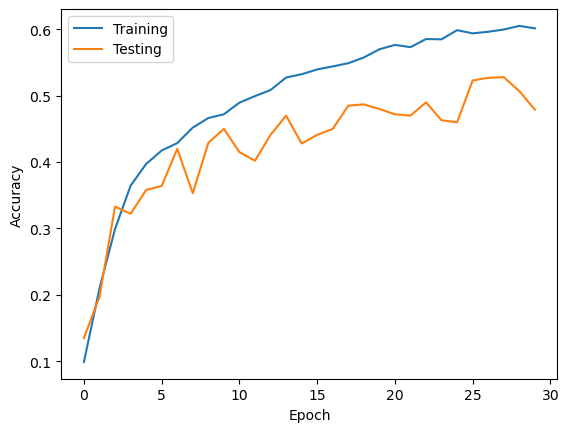

In [10]:
stats.plot(path=trained_folder+ "/")

## 1:10 ratio

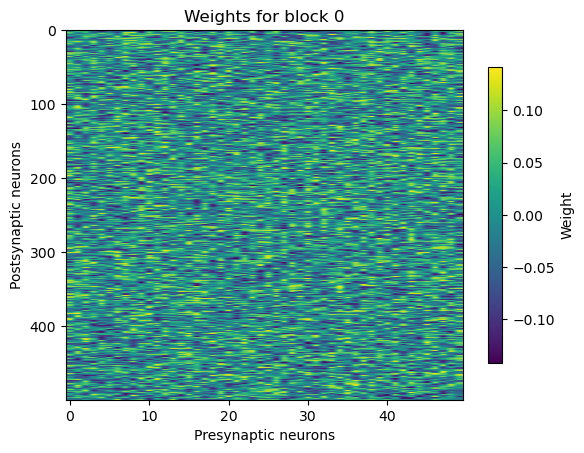

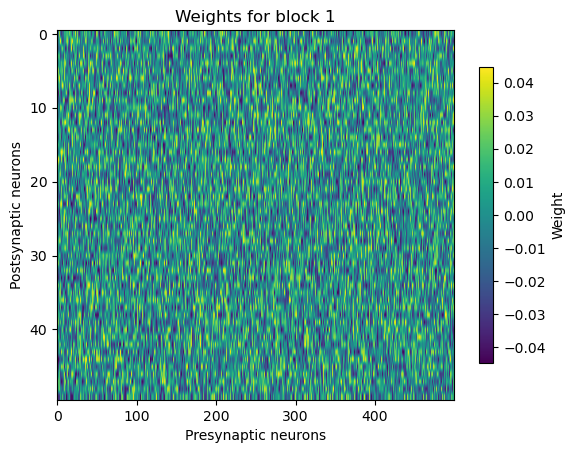

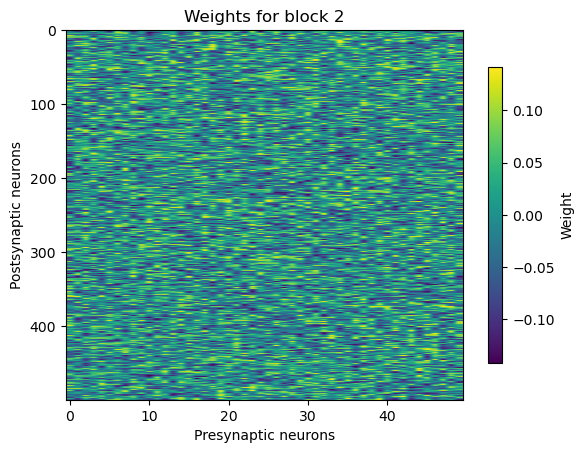

In [29]:
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

layer_sizes = [50, 500, 50, 500]   

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=False, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

In [30]:
trained_folder = 'Trained/1_to_10'
os.makedirs(trained_folder, exist_ok=True)

epochs = 30
for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter): 
        output, count = assistant.train(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Testing
    test_iter = iter(testing_loader) 
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Saving network if best performance so far
    # if stats.testing.best_accuracy:
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_1to10_30epochs_epoch_{epoch_i}.pt')
    stats.update()
    stats.save(path= trained_folder+ "/")

100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


[Epoch  0/30] Train loss =    16.69117                          accuracy = 0.13940 

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


[Epoch  0/30] Train loss =    16.69117                          accuracy = 0.13940  | Test  loss =     8.21039                          accuracy = 0.21400 

100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


[Epoch  1/30] Train loss =     7.68622 (min =    16.69117)     accuracy = 0.27920 (max = 0.13940) 

100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


[Epoch  1/30] Train loss =     7.68622 (min =    16.69117)     accuracy = 0.27920 (max = 0.13940)  | Test  loss =     7.98360 (min =     8.21039)     accuracy = 0.27900 (max = 0.21400) 

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


[Epoch  2/30] Train loss =     7.34526 (min =     7.68622)     accuracy = 0.35060 (max = 0.27920) 

100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


[Epoch  2/30] Train loss =     7.34526 (min =     7.68622)     accuracy = 0.35060 (max = 0.27920)  | Test  loss =     7.72512 (min =     7.98360)     accuracy = 0.30200 (max = 0.27900) 

100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


[Epoch  3/30] Train loss =     7.09364 (min =     7.34526)     accuracy = 0.37280 (max = 0.35060) 

100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


[Epoch  3/30] Train loss =     7.09364 (min =     7.34526)     accuracy = 0.37280 (max = 0.35060)  | Test  loss =     7.49778 (min =     7.72512)     accuracy = 0.32900 (max = 0.30200) 

100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


[Epoch  4/30] Train loss =     6.98240 (min =     7.09364)     accuracy = 0.38640 (max = 0.37280) 

100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


[Epoch  4/30] Train loss =     6.98240 (min =     7.09364)     accuracy = 0.38640 (max = 0.37280)  | Test  loss =     7.46209 (min =     7.49778)     accuracy = 0.34400 (max = 0.32900) 

100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


[Epoch  5/30] Train loss =     6.79852 (min =     6.98240)     accuracy = 0.41520 (max = 0.38640) 

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


[Epoch  5/30] Train loss =     6.79852 (min =     6.98240)     accuracy = 0.41520 (max = 0.38640)  | Test  loss =     7.33027 (min =     7.46209)     accuracy = 0.31300 (max = 0.34400) 

100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


[Epoch  6/30] Train loss =     6.64621 (min =     6.79852)     accuracy = 0.44840 (max = 0.41520) 

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


[Epoch  6/30] Train loss =     6.64621 (min =     6.79852)     accuracy = 0.44840 (max = 0.41520)  | Test  loss =     7.18834 (min =     7.33027)     accuracy = 0.37200 (max = 0.34400) 

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


[Epoch  7/30] Train loss =     6.53840 (min =     6.64621)     accuracy = 0.46200 (max = 0.44840) 

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


[Epoch  7/30] Train loss =     6.53840 (min =     6.64621)     accuracy = 0.46200 (max = 0.44840)  | Test  loss =     7.13002 (min =     7.18834)     accuracy = 0.40100 (max = 0.37200) 

100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


[Epoch  8/30] Train loss =     6.40090 (min =     6.53840)     accuracy = 0.47740 (max = 0.46200) 

100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


[Epoch  8/30] Train loss =     6.40090 (min =     6.53840)     accuracy = 0.47740 (max = 0.46200)  | Test  loss =     7.09036 (min =     7.13002)     accuracy = 0.40300 (max = 0.40100) 

100%|██████████| 20/20 [00:26<00:00,  1.30s/it]


[Epoch  9/30] Train loss =     6.32042 (min =     6.40090)     accuracy = 0.50340 (max = 0.47740) 

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


[Epoch  9/30] Train loss =     6.32042 (min =     6.40090)     accuracy = 0.50340 (max = 0.47740)  | Test  loss =     6.96233 (min =     7.09036)     accuracy = 0.43600 (max = 0.40300) 

100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


[Epoch 10/30] Train loss =     6.25336 (min =     6.32042)     accuracy = 0.50960 (max = 0.50340) 

100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


[Epoch 10/30] Train loss =     6.25336 (min =     6.32042)     accuracy = 0.50960 (max = 0.50340)  | Test  loss =     6.99691 (min =     6.96233)     accuracy = 0.38500 (max = 0.43600) 

100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


[Epoch 11/30] Train loss =     6.20170 (min =     6.25336)     accuracy = 0.53100 (max = 0.50960) 

100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


[Epoch 11/30] Train loss =     6.20170 (min =     6.25336)     accuracy = 0.53100 (max = 0.50960)  | Test  loss =     6.87082 (min =     6.96233)     accuracy = 0.45400 (max = 0.43600) 

100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


[Epoch 12/30] Train loss =     6.19047 (min =     6.20170)     accuracy = 0.54700 (max = 0.53100) 

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


[Epoch 12/30] Train loss =     6.19047 (min =     6.20170)     accuracy = 0.54700 (max = 0.53100)  | Test  loss =     6.98488 (min =     6.87082)     accuracy = 0.48300 (max = 0.45400) 

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


[Epoch 13/30] Train loss =     6.15156 (min =     6.19047)     accuracy = 0.56660 (max = 0.54700) 

100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


[Epoch 13/30] Train loss =     6.15156 (min =     6.19047)     accuracy = 0.56660 (max = 0.54700)  | Test  loss =     6.98374 (min =     6.87082)     accuracy = 0.46300 (max = 0.48300) 

100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


[Epoch 14/30] Train loss =     6.16016 (min =     6.15156)     accuracy = 0.57540 (max = 0.56660) 

100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


[Epoch 14/30] Train loss =     6.16016 (min =     6.15156)     accuracy = 0.57540 (max = 0.56660)  | Test  loss =     6.95415 (min =     6.87082)     accuracy = 0.46700 (max = 0.48300) 

100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


[Epoch 15/30] Train loss =     6.15931 (min =     6.15156)     accuracy = 0.58680 (max = 0.57540) 

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


[Epoch 15/30] Train loss =     6.15931 (min =     6.15156)     accuracy = 0.58680 (max = 0.57540)  | Test  loss =     6.99867 (min =     6.87082)     accuracy = 0.40300 (max = 0.48300) 

100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


[Epoch 16/30] Train loss =     6.15619 (min =     6.15156)     accuracy = 0.57560 (max = 0.58680) 

100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


[Epoch 16/30] Train loss =     6.15619 (min =     6.15156)     accuracy = 0.57560 (max = 0.58680)  | Test  loss =     6.98582 (min =     6.87082)     accuracy = 0.44800 (max = 0.48300) 

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


[Epoch 17/30] Train loss =     6.08868 (min =     6.15156)     accuracy = 0.59260 (max = 0.58680) 

100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


[Epoch 17/30] Train loss =     6.08868 (min =     6.15156)     accuracy = 0.59260 (max = 0.58680)  | Test  loss =     6.82046 (min =     6.87082)     accuracy = 0.51100 (max = 0.48300) 

100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


[Epoch 18/30] Train loss =     5.99039 (min =     6.08868)     accuracy = 0.60520 (max = 0.59260) 

100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


[Epoch 18/30] Train loss =     5.99039 (min =     6.08868)     accuracy = 0.60520 (max = 0.59260)  | Test  loss =     6.77748 (min =     6.82046)     accuracy = 0.50400 (max = 0.51100) 

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


[Epoch 19/30] Train loss =     5.95268 (min =     5.99039)     accuracy = 0.61160 (max = 0.60520) 

100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


[Epoch 19/30] Train loss =     5.95268 (min =     5.99039)     accuracy = 0.61160 (max = 0.60520)  | Test  loss =     6.63298 (min =     6.77748)     accuracy = 0.53700 (max = 0.51100) 

100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


[Epoch 20/30] Train loss =     5.83625 (min =     5.95268)     accuracy = 0.62640 (max = 0.61160) 

100%|██████████| 4/4 [00:03<00:00,  1.05it/s]


[Epoch 20/30] Train loss =     5.83625 (min =     5.95268)     accuracy = 0.62640 (max = 0.61160)  | Test  loss =     6.70833 (min =     6.63298)     accuracy = 0.47800 (max = 0.53700) 

100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


[Epoch 21/30] Train loss =     5.78675 (min =     5.83625)     accuracy = 0.62340 (max = 0.62640) 

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


[Epoch 21/30] Train loss =     5.78675 (min =     5.83625)     accuracy = 0.62340 (max = 0.62640)  | Test  loss =     6.76563 (min =     6.63298)     accuracy = 0.42600 (max = 0.53700) 

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


[Epoch 22/30] Train loss =     5.69512 (min =     5.78675)     accuracy = 0.62900 (max = 0.62640) 

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


[Epoch 22/30] Train loss =     5.69512 (min =     5.78675)     accuracy = 0.62900 (max = 0.62640)  | Test  loss =     6.71592 (min =     6.63298)     accuracy = 0.50100 (max = 0.53700) 

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


[Epoch 23/30] Train loss =     5.66263 (min =     5.69512)     accuracy = 0.64380 (max = 0.62900) 

100%|██████████| 4/4 [00:04<00:00,  1.01s/it]


[Epoch 23/30] Train loss =     5.66263 (min =     5.69512)     accuracy = 0.64380 (max = 0.62900)  | Test  loss =     6.65817 (min =     6.63298)     accuracy = 0.50200 (max = 0.53700) 

100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


[Epoch 24/30] Train loss =     5.59743 (min =     5.66263)     accuracy = 0.65080 (max = 0.64380) 

100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


[Epoch 24/30] Train loss =     5.59743 (min =     5.66263)     accuracy = 0.65080 (max = 0.64380)  | Test  loss =     6.67769 (min =     6.63298)     accuracy = 0.50800 (max = 0.53700) 

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


[Epoch 25/30] Train loss =     5.54775 (min =     5.59743)     accuracy = 0.64640 (max = 0.65080) 

100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


[Epoch 25/30] Train loss =     5.54775 (min =     5.59743)     accuracy = 0.64640 (max = 0.65080)  | Test  loss =     6.58337 (min =     6.63298)     accuracy = 0.51500 (max = 0.53700) 

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


[Epoch 26/30] Train loss =     5.49759 (min =     5.54775)     accuracy = 0.65440 (max = 0.65080) 

100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


[Epoch 26/30] Train loss =     5.49759 (min =     5.54775)     accuracy = 0.65440 (max = 0.65080)  | Test  loss =     6.66321 (min =     6.58337)     accuracy = 0.48800 (max = 0.53700) 

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


[Epoch 27/30] Train loss =     5.46894 (min =     5.49759)     accuracy = 0.66020 (max = 0.65440) 

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


[Epoch 27/30] Train loss =     5.46894 (min =     5.49759)     accuracy = 0.66020 (max = 0.65440)  | Test  loss =     6.49000 (min =     6.58337)     accuracy = 0.53900 (max = 0.53700) 

100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


[Epoch 28/30] Train loss =     5.40658 (min =     5.46894)     accuracy = 0.67460 (max = 0.66020) 

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


[Epoch 28/30] Train loss =     5.40658 (min =     5.46894)     accuracy = 0.67460 (max = 0.66020)  | Test  loss =     6.31964 (min =     6.49000)     accuracy = 0.55600 (max = 0.53900) 

100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


[Epoch 29/30] Train loss =     5.39653 (min =     5.40658)     accuracy = 0.66480 (max = 0.67460) 

100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

[Epoch 29/30] Train loss =     5.39653 (min =     5.40658)     accuracy = 0.66480 (max = 0.67460)  | Test  loss =     6.35496 (min =     6.31964)     accuracy = 0.57200 (max = 0.55600) 

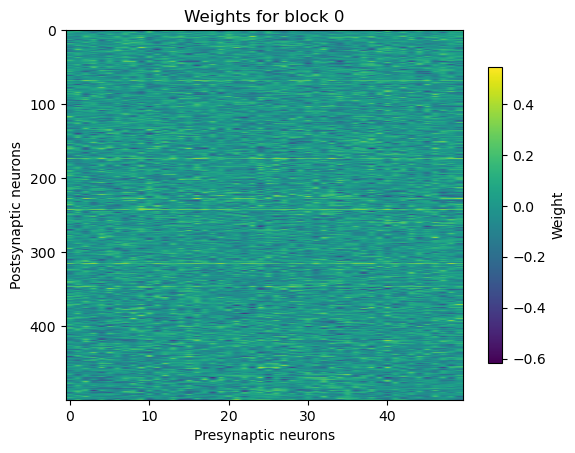

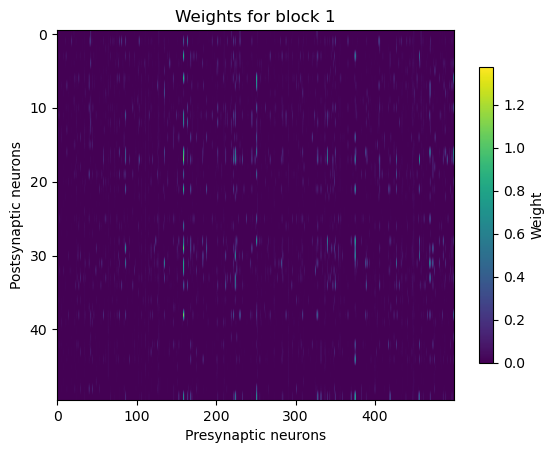

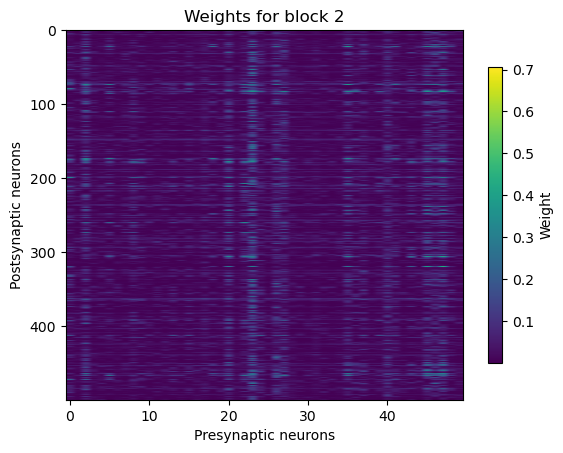

In [31]:
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

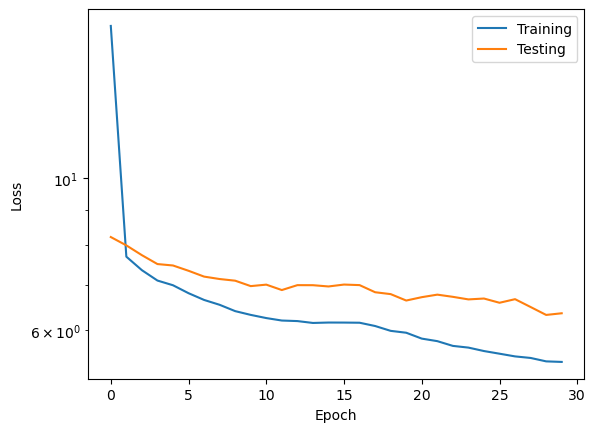

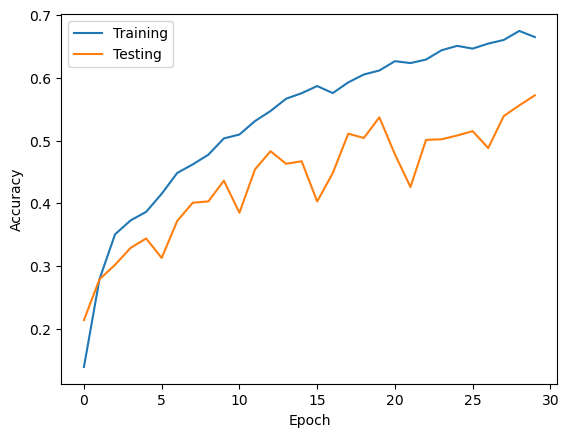

In [32]:
stats.plot(path=trained_folder+ "/")

## 1:50 ratio

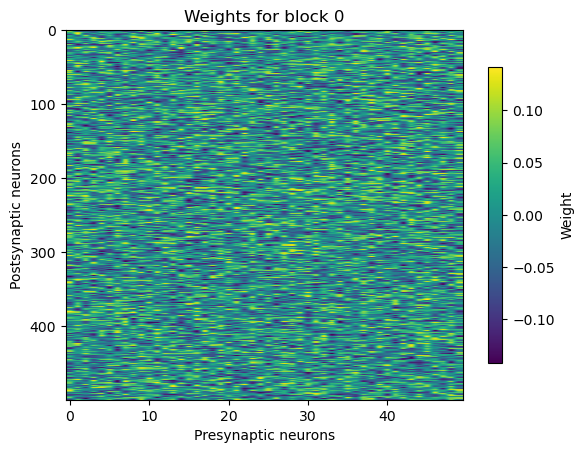

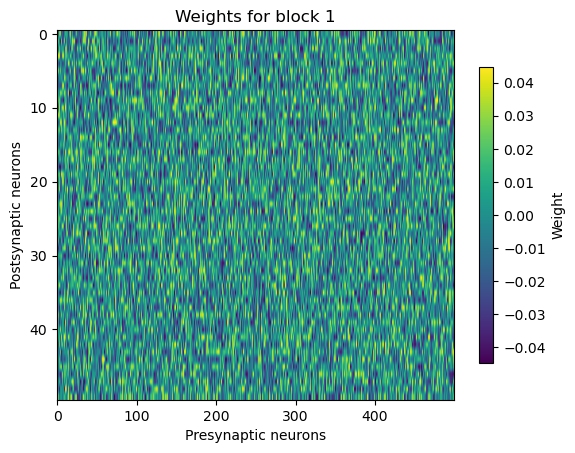

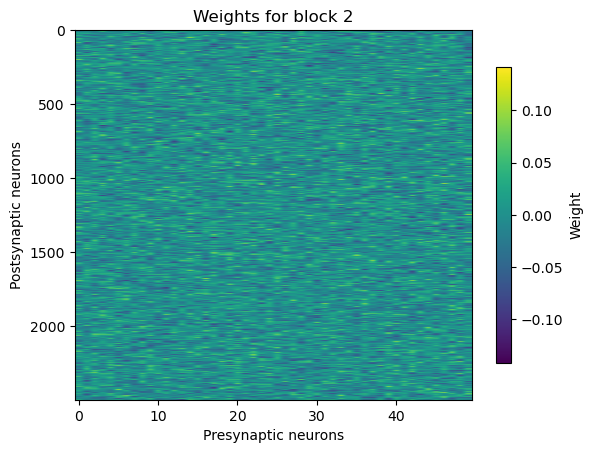

In [35]:
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

layer_sizes = [50, 500, 50, 2500] 

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate,
    stdp_tau_combined, train_hybrid=False, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

In [36]:
trained_folder = 'Trained/1_to_50'
os.makedirs(trained_folder, exist_ok=True)

epochs = 30
for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter): 
        output, count = assistant.train(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Testing
    test_iter = iter(testing_loader) 
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Saving network if best performance so far
    # if stats.testing.best_accuracy:
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_1to50_30epochs_epoch_{epoch_i}.pt')
    stats.update()
    stats.save(path= trained_folder+ "/")

100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch  0/30] Train loss =    13.04541                          accuracy = 0.10100 

100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


[Epoch  0/30] Train loss =    13.04541                          accuracy = 0.10100  | Test  loss =     7.99054                          accuracy = 0.20300 

100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


[Epoch  1/30] Train loss =     7.31761 (min =    13.04541)     accuracy = 0.26260 (max = 0.10100) 

100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


[Epoch  1/30] Train loss =     7.31761 (min =    13.04541)     accuracy = 0.26260 (max = 0.10100)  | Test  loss =     7.44088 (min =     7.99054)     accuracy = 0.28600 (max = 0.20300) 

100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


[Epoch  2/30] Train loss =     6.96961 (min =     7.31761)     accuracy = 0.32520 (max = 0.26260) 

100%|██████████| 4/4 [00:09<00:00,  2.48s/it]


[Epoch  2/30] Train loss =     6.96961 (min =     7.31761)     accuracy = 0.32520 (max = 0.26260)  | Test  loss =     7.23160 (min =     7.44088)     accuracy = 0.29700 (max = 0.28600) 

100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


[Epoch  3/30] Train loss =     6.72023 (min =     6.96961)     accuracy = 0.35080 (max = 0.32520) 

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


[Epoch  3/30] Train loss =     6.72023 (min =     6.96961)     accuracy = 0.35080 (max = 0.32520)  | Test  loss =     7.13404 (min =     7.23160)     accuracy = 0.31700 (max = 0.29700) 

100%|██████████| 20/20 [00:58<00:00,  2.94s/it]


[Epoch  4/30] Train loss =     6.63243 (min =     6.72023)     accuracy = 0.39040 (max = 0.35080) 

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


[Epoch  4/30] Train loss =     6.63243 (min =     6.72023)     accuracy = 0.39040 (max = 0.35080)  | Test  loss =     7.07187 (min =     7.13404)     accuracy = 0.39700 (max = 0.31700) 

100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


[Epoch  5/30] Train loss =     6.50595 (min =     6.63243)     accuracy = 0.44080 (max = 0.39040) 

100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


[Epoch  5/30] Train loss =     6.50595 (min =     6.63243)     accuracy = 0.44080 (max = 0.39040)  | Test  loss =     7.15977 (min =     7.07187)     accuracy = 0.34400 (max = 0.39700) 

100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


[Epoch  6/30] Train loss =     6.36688 (min =     6.50595)     accuracy = 0.46520 (max = 0.44080) 

100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


[Epoch  6/30] Train loss =     6.36688 (min =     6.50595)     accuracy = 0.46520 (max = 0.44080)  | Test  loss =     6.97679 (min =     7.07187)     accuracy = 0.38800 (max = 0.39700) 

100%|██████████| 20/20 [00:57<00:00,  2.90s/it]


[Epoch  7/30] Train loss =     6.28662 (min =     6.36688)     accuracy = 0.47840 (max = 0.46520) 

100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


[Epoch  7/30] Train loss =     6.28662 (min =     6.36688)     accuracy = 0.47840 (max = 0.46520)  | Test  loss =     6.91845 (min =     6.97679)     accuracy = 0.37600 (max = 0.39700) 

100%|██████████| 20/20 [00:58<00:00,  2.94s/it]


[Epoch  8/30] Train loss =     6.24725 (min =     6.28662)     accuracy = 0.49960 (max = 0.47840) 

100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


[Epoch  8/30] Train loss =     6.24725 (min =     6.28662)     accuracy = 0.49960 (max = 0.47840)  | Test  loss =     6.97385 (min =     6.91845)     accuracy = 0.40600 (max = 0.39700) 

100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


[Epoch  9/30] Train loss =     6.25385 (min =     6.24725)     accuracy = 0.50800 (max = 0.49960) 

100%|██████████| 4/4 [00:09<00:00,  2.31s/it]


[Epoch  9/30] Train loss =     6.25385 (min =     6.24725)     accuracy = 0.50800 (max = 0.49960)  | Test  loss =     7.19765 (min =     6.91845)     accuracy = 0.39200 (max = 0.40600) 

100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


[Epoch 10/30] Train loss =     6.26530 (min =     6.24725)     accuracy = 0.51600 (max = 0.50800) 

100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


[Epoch 10/30] Train loss =     6.26530 (min =     6.24725)     accuracy = 0.51600 (max = 0.50800)  | Test  loss =     7.60268 (min =     6.91845)     accuracy = 0.28900 (max = 0.40600) 

100%|██████████| 20/20 [00:58<00:00,  2.95s/it]


[Epoch 11/30] Train loss =     6.29159 (min =     6.24725)     accuracy = 0.51220 (max = 0.51600) 

100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


[Epoch 11/30] Train loss =     6.29159 (min =     6.24725)     accuracy = 0.51220 (max = 0.51600)  | Test  loss =     7.84917 (min =     6.91845)     accuracy = 0.35500 (max = 0.40600) 

100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


[Epoch 12/30] Train loss =     6.33283 (min =     6.24725)     accuracy = 0.52000 (max = 0.51600) 

100%|██████████| 4/4 [00:09<00:00,  2.44s/it]


[Epoch 12/30] Train loss =     6.33283 (min =     6.24725)     accuracy = 0.52000 (max = 0.51600)  | Test  loss =     7.44919 (min =     6.91845)     accuracy = 0.37900 (max = 0.40600) 

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


[Epoch 13/30] Train loss =     6.32466 (min =     6.24725)     accuracy = 0.51940 (max = 0.52000) 

100%|██████████| 4/4 [00:09<00:00,  2.50s/it]


[Epoch 13/30] Train loss =     6.32466 (min =     6.24725)     accuracy = 0.51940 (max = 0.52000)  | Test  loss =     7.44673 (min =     6.91845)     accuracy = 0.40600 (max = 0.40600) 

100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


[Epoch 14/30] Train loss =     6.35022 (min =     6.24725)     accuracy = 0.53960 (max = 0.52000) 

100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


[Epoch 14/30] Train loss =     6.35022 (min =     6.24725)     accuracy = 0.53960 (max = 0.52000)  | Test  loss =     7.21477 (min =     6.91845)     accuracy = 0.44100 (max = 0.40600) 

100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


[Epoch 15/30] Train loss =     6.34914 (min =     6.24725)     accuracy = 0.54300 (max = 0.53960) 

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


[Epoch 15/30] Train loss =     6.34914 (min =     6.24725)     accuracy = 0.54300 (max = 0.53960)  | Test  loss =     7.41733 (min =     6.91845)     accuracy = 0.32500 (max = 0.44100) 

100%|██████████| 20/20 [00:58<00:00,  2.94s/it]


[Epoch 16/30] Train loss =     6.40519 (min =     6.24725)     accuracy = 0.55040 (max = 0.54300) 

100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


[Epoch 16/30] Train loss =     6.40519 (min =     6.24725)     accuracy = 0.55040 (max = 0.54300)  | Test  loss =     7.24651 (min =     6.91845)     accuracy = 0.44300 (max = 0.44100) 

100%|██████████| 20/20 [00:56<00:00,  2.82s/it]


[Epoch 17/30] Train loss =     6.45752 (min =     6.24725)     accuracy = 0.57260 (max = 0.55040) 

100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


[Epoch 17/30] Train loss =     6.45752 (min =     6.24725)     accuracy = 0.57260 (max = 0.55040)  | Test  loss =     7.31782 (min =     6.91845)     accuracy = 0.48000 (max = 0.44300) 

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


[Epoch 18/30] Train loss =     6.48261 (min =     6.24725)     accuracy = 0.56880 (max = 0.57260) 

100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


[Epoch 18/30] Train loss =     6.48261 (min =     6.24725)     accuracy = 0.56880 (max = 0.57260)  | Test  loss =     7.17093 (min =     6.91845)     accuracy = 0.44200 (max = 0.48000) 

100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


[Epoch 19/30] Train loss =     6.28220 (min =     6.24725)     accuracy = 0.58480 (max = 0.57260) 

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


[Epoch 19/30] Train loss =     6.28220 (min =     6.24725)     accuracy = 0.58480 (max = 0.57260)  | Test  loss =     7.15298 (min =     6.91845)     accuracy = 0.43200 (max = 0.48000) 

100%|██████████| 20/20 [00:58<00:00,  2.94s/it]


[Epoch 20/30] Train loss =     6.16971 (min =     6.24725)     accuracy = 0.59460 (max = 0.58480) 

100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


[Epoch 20/30] Train loss =     6.16971 (min =     6.24725)     accuracy = 0.59460 (max = 0.58480)  | Test  loss =     7.18020 (min =     6.91845)     accuracy = 0.38300 (max = 0.48000) 

100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


[Epoch 21/30] Train loss =     6.11645 (min =     6.16971)     accuracy = 0.59840 (max = 0.59460) 

100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


[Epoch 21/30] Train loss =     6.11645 (min =     6.16971)     accuracy = 0.59840 (max = 0.59460)  | Test  loss =     7.03066 (min =     6.91845)     accuracy = 0.47200 (max = 0.48000) 

100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


[Epoch 22/30] Train loss =     5.97197 (min =     6.11645)     accuracy = 0.60920 (max = 0.59840) 

100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


[Epoch 22/30] Train loss =     5.97197 (min =     6.11645)     accuracy = 0.60920 (max = 0.59840)  | Test  loss =     6.88377 (min =     6.91845)     accuracy = 0.49000 (max = 0.48000) 

100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


[Epoch 23/30] Train loss =     5.90194 (min =     5.97197)     accuracy = 0.62180 (max = 0.60920) 

100%|██████████| 4/4 [00:09<00:00,  2.26s/it]


[Epoch 23/30] Train loss =     5.90194 (min =     5.97197)     accuracy = 0.62180 (max = 0.60920)  | Test  loss =     7.02943 (min =     6.88377)     accuracy = 0.45500 (max = 0.49000) 

100%|██████████| 20/20 [00:58<00:00,  2.90s/it]


[Epoch 24/30] Train loss =     5.83784 (min =     5.90194)     accuracy = 0.61920 (max = 0.62180) 

100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


[Epoch 24/30] Train loss =     5.83784 (min =     5.90194)     accuracy = 0.61920 (max = 0.62180)  | Test  loss =     6.73976 (min =     6.88377)     accuracy = 0.52900 (max = 0.49000) 

100%|██████████| 20/20 [00:58<00:00,  2.92s/it]


[Epoch 25/30] Train loss =     5.74975 (min =     5.83784)     accuracy = 0.63020 (max = 0.62180) 

100%|██████████| 4/4 [00:10<00:00,  2.53s/it]


[Epoch 25/30] Train loss =     5.74975 (min =     5.83784)     accuracy = 0.63020 (max = 0.62180)  | Test  loss =     6.71185 (min =     6.73976)     accuracy = 0.46400 (max = 0.52900) 

100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch 26/30] Train loss =     5.73028 (min =     5.74975)     accuracy = 0.62520 (max = 0.63020) 

100%|██████████| 4/4 [00:10<00:00,  2.50s/it]


[Epoch 26/30] Train loss =     5.73028 (min =     5.74975)     accuracy = 0.62520 (max = 0.63020)  | Test  loss =     6.59982 (min =     6.71185)     accuracy = 0.51700 (max = 0.52900) 

100%|██████████| 20/20 [00:59<00:00,  2.96s/it]


[Epoch 27/30] Train loss =     5.64413 (min =     5.73028)     accuracy = 0.63620 (max = 0.63020) 

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


[Epoch 27/30] Train loss =     5.64413 (min =     5.73028)     accuracy = 0.63620 (max = 0.63020)  | Test  loss =     6.78936 (min =     6.59982)     accuracy = 0.49200 (max = 0.52900) 

100%|██████████| 20/20 [01:00<00:00,  3.01s/it]


[Epoch 28/30] Train loss =     5.56620 (min =     5.64413)     accuracy = 0.63400 (max = 0.63620) 

100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


[Epoch 28/30] Train loss =     5.56620 (min =     5.64413)     accuracy = 0.63400 (max = 0.63620)  | Test  loss =     6.69141 (min =     6.59982)     accuracy = 0.50700 (max = 0.52900) 

100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


[Epoch 29/30] Train loss =     5.48511 (min =     5.56620)     accuracy = 0.64880 (max = 0.63620) 

100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

[Epoch 29/30] Train loss =     5.48511 (min =     5.56620)     accuracy = 0.64880 (max = 0.63620)  | Test  loss =     6.69876 (min =     6.59982)     accuracy = 0.50800 (max = 0.52900) 

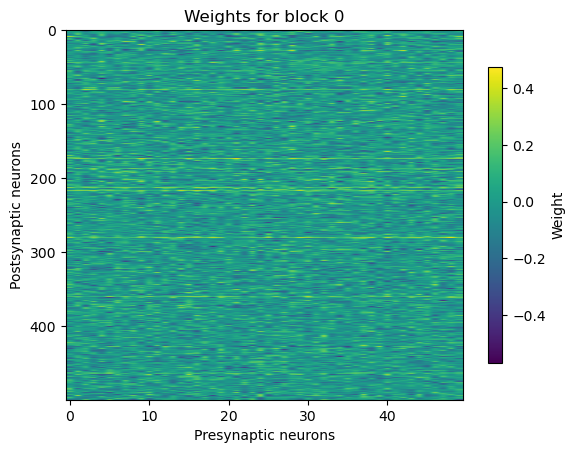

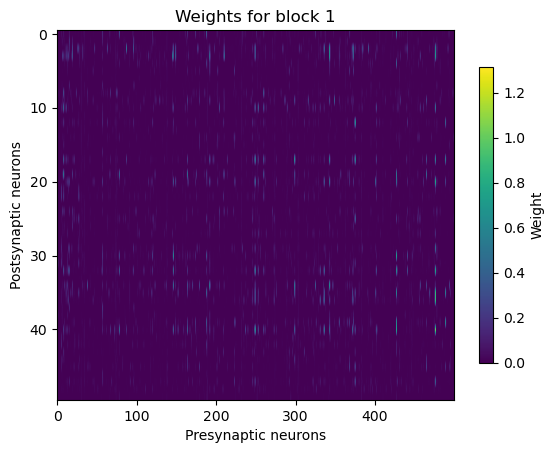

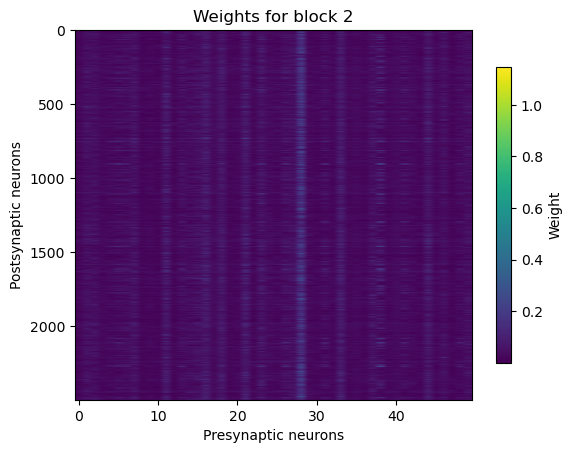

In [37]:
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

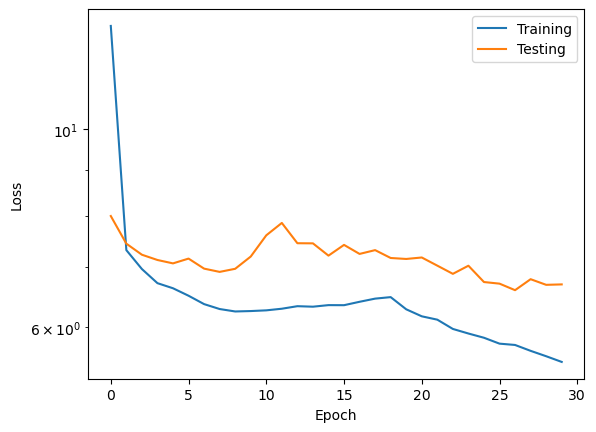

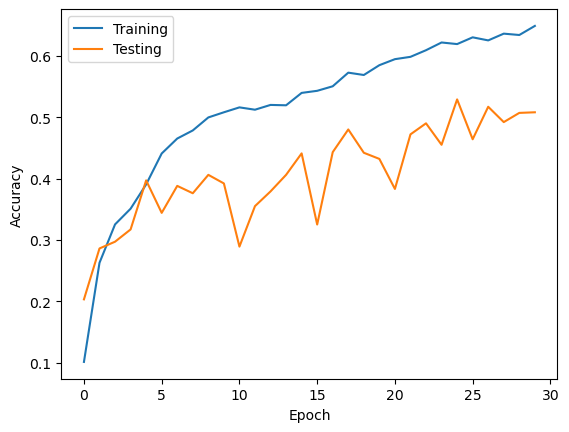

In [38]:
stats.plot(path=trained_folder+ "/")

## 1:100 ratio

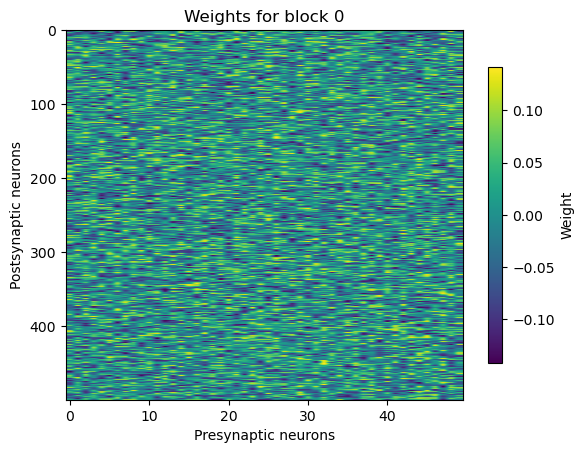

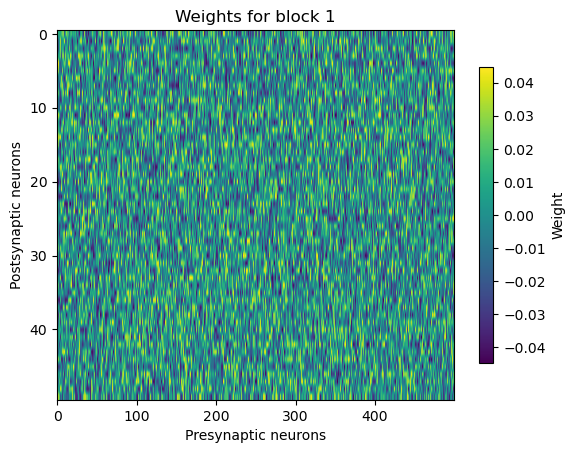

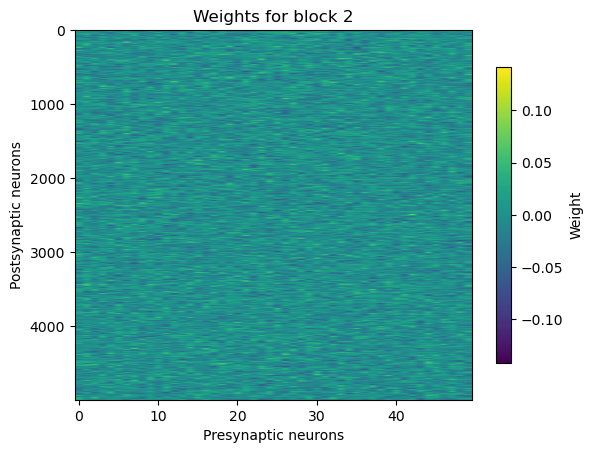

In [39]:
train_x = load(os.path.join(data_folder, 'train_x.npy'))
train_y = load(os.path.join(data_folder, 'train_y.npy'))
val_x = load(os.path.join(data_folder, 'val_x.npy'))
val_y = load(os.path.join(data_folder, 'val_y.npy'))

train_dataset = ORDataset(train_x, train_y)
test_dataset = ORDataset(val_x, val_y)

training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

layer_sizes = [50, 500, 50, 5000]  

hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=False, burn_in=50).to(device)

error = DECOLLELoss(torch.nn.SmoothL1Loss, reduction='mean')
optimizer = torch.optim.Adam(hybrid_network.parameters(), lr=0.0001)

stats = slayer.utils.LearningStats()
assistant = HybridAssistant(hybrid_network, error, optimizer, stats,
                             classifier=slayer.classifier.Rate.predict, count_log=True)

for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

In [40]:
trained_folder = 'Trained/1_to_100'
os.makedirs(trained_folder, exist_ok=True)

epochs = 30
for epoch_i, epoch in enumerate(range(epochs)):

    # Training
    train_iter = iter(training_loader)
    for (inputs, label) in tqdm(train_iter): 
        output, count = assistant.train(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')
    
    # Testing
    test_iter = iter(testing_loader) 
    for (inputs, label) in tqdm(test_iter):
        output, count = assistant.test(
            inputs, one_hot(label.to(torch.int64), num_classes=n_class))
    print(f'\r[Epoch {epoch:2d}/{epochs}] {stats}', end='')

    # Saving network if best performance so far
    # if stats.testing.best_accuracy:
    torch.save(hybrid_network.state_dict(), trained_folder + f'/network_1to100_30epochs_epoch_{epoch_i}.pt')
    stats.update()
    stats.save(path= trained_folder+ "/")

100%|██████████| 20/20 [01:22<00:00,  4.11s/it]


[Epoch  0/30] Train loss =    14.31083                          accuracy = 0.13240 

100%|██████████| 4/4 [00:12<00:00,  3.21s/it]


[Epoch  0/30] Train loss =    14.31083                          accuracy = 0.13240  | Test  loss =     8.26246                          accuracy = 0.12700 

100%|██████████| 20/20 [01:18<00:00,  3.93s/it]


[Epoch  1/30] Train loss =     7.48556 (min =    14.31083)     accuracy = 0.23180 (max = 0.13240) 

100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


[Epoch  1/30] Train loss =     7.48556 (min =    14.31083)     accuracy = 0.23180 (max = 0.13240)  | Test  loss =     7.57291 (min =     8.26246)     accuracy = 0.26300 (max = 0.12700) 

100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


[Epoch  2/30] Train loss =     6.98038 (min =     7.48556)     accuracy = 0.34320 (max = 0.23180) 

100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


[Epoch  2/30] Train loss =     6.98038 (min =     7.48556)     accuracy = 0.34320 (max = 0.23180)  | Test  loss =     7.27099 (min =     7.57291)     accuracy = 0.32200 (max = 0.26300) 

100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


[Epoch  3/30] Train loss =     6.71237 (min =     6.98038)     accuracy = 0.39580 (max = 0.34320) 

100%|██████████| 4/4 [00:12<00:00,  3.15s/it]


[Epoch  3/30] Train loss =     6.71237 (min =     6.98038)     accuracy = 0.39580 (max = 0.34320)  | Test  loss =     7.03187 (min =     7.27099)     accuracy = 0.32800 (max = 0.32200) 

100%|██████████| 20/20 [01:19<00:00,  3.98s/it]


[Epoch  4/30] Train loss =     6.56517 (min =     6.71237)     accuracy = 0.44240 (max = 0.39580) 

100%|██████████| 4/4 [00:12<00:00,  3.21s/it]


[Epoch  4/30] Train loss =     6.56517 (min =     6.71237)     accuracy = 0.44240 (max = 0.39580)  | Test  loss =     6.94065 (min =     7.03187)     accuracy = 0.36600 (max = 0.32800) 

100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


[Epoch  5/30] Train loss =     6.44081 (min =     6.56517)     accuracy = 0.46940 (max = 0.44240) 

100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


[Epoch  5/30] Train loss =     6.44081 (min =     6.56517)     accuracy = 0.46940 (max = 0.44240)  | Test  loss =     7.00559 (min =     6.94065)     accuracy = 0.31900 (max = 0.36600) 

100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


[Epoch  6/30] Train loss =     6.37338 (min =     6.44081)     accuracy = 0.48420 (max = 0.46940) 

100%|██████████| 4/4 [00:12<00:00,  3.18s/it]


[Epoch  6/30] Train loss =     6.37338 (min =     6.44081)     accuracy = 0.48420 (max = 0.46940)  | Test  loss =     7.08423 (min =     6.94065)     accuracy = 0.39800 (max = 0.36600) 

100%|██████████| 20/20 [01:19<00:00,  3.98s/it]


[Epoch  7/30] Train loss =     6.29655 (min =     6.37338)     accuracy = 0.50060 (max = 0.48420) 

100%|██████████| 4/4 [00:13<00:00,  3.26s/it]


[Epoch  7/30] Train loss =     6.29655 (min =     6.37338)     accuracy = 0.50060 (max = 0.48420)  | Test  loss =     6.94749 (min =     6.94065)     accuracy = 0.36300 (max = 0.39800) 

100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


[Epoch  8/30] Train loss =     6.23712 (min =     6.29655)     accuracy = 0.49760 (max = 0.50060) 

100%|██████████| 4/4 [00:13<00:00,  3.26s/it]


[Epoch  8/30] Train loss =     6.23712 (min =     6.29655)     accuracy = 0.49760 (max = 0.50060)  | Test  loss =     7.31758 (min =     6.94065)     accuracy = 0.37800 (max = 0.39800) 

100%|██████████| 20/20 [01:20<00:00,  4.01s/it]


[Epoch  9/30] Train loss =     6.24607 (min =     6.23712)     accuracy = 0.50540 (max = 0.50060) 

100%|██████████| 4/4 [00:12<00:00,  3.17s/it]


[Epoch  9/30] Train loss =     6.24607 (min =     6.23712)     accuracy = 0.50540 (max = 0.50060)  | Test  loss =     7.21589 (min =     6.94065)     accuracy = 0.41700 (max = 0.39800) 

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


[Epoch 10/30] Train loss =     6.29825 (min =     6.23712)     accuracy = 0.51060 (max = 0.50540) 

100%|██████████| 4/4 [00:12<00:00,  3.18s/it]


[Epoch 10/30] Train loss =     6.29825 (min =     6.23712)     accuracy = 0.51060 (max = 0.50540)  | Test  loss =     7.21108 (min =     6.94065)     accuracy = 0.37800 (max = 0.41700) 

100%|██████████| 20/20 [01:20<00:00,  4.04s/it]


[Epoch 11/30] Train loss =     6.36102 (min =     6.23712)     accuracy = 0.51600 (max = 0.51060) 

100%|██████████| 4/4 [00:12<00:00,  3.22s/it]


[Epoch 11/30] Train loss =     6.36102 (min =     6.23712)     accuracy = 0.51600 (max = 0.51060)  | Test  loss =     7.11278 (min =     6.94065)     accuracy = 0.34900 (max = 0.41700) 

100%|██████████| 20/20 [01:20<00:00,  4.00s/it]


[Epoch 12/30] Train loss =     6.44982 (min =     6.23712)     accuracy = 0.51020 (max = 0.51600) 

100%|██████████| 4/4 [00:12<00:00,  3.24s/it]


[Epoch 12/30] Train loss =     6.44982 (min =     6.23712)     accuracy = 0.51020 (max = 0.51600)  | Test  loss =     7.38351 (min =     6.94065)     accuracy = 0.36300 (max = 0.41700) 

100%|██████████| 20/20 [01:20<00:00,  4.00s/it]


[Epoch 13/30] Train loss =     6.56916 (min =     6.23712)     accuracy = 0.51160 (max = 0.51600) 

100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


[Epoch 13/30] Train loss =     6.56916 (min =     6.23712)     accuracy = 0.51160 (max = 0.51600)  | Test  loss =     8.26017 (min =     6.94065)     accuracy = 0.38100 (max = 0.41700) 

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


[Epoch 14/30] Train loss =     6.66937 (min =     6.23712)     accuracy = 0.52700 (max = 0.51600) 

100%|██████████| 4/4 [00:12<00:00,  3.19s/it]


[Epoch 14/30] Train loss =     6.66937 (min =     6.23712)     accuracy = 0.52700 (max = 0.51600)  | Test  loss =     7.38656 (min =     6.94065)     accuracy = 0.35300 (max = 0.41700) 

100%|██████████| 20/20 [01:21<00:00,  4.05s/it]


[Epoch 15/30] Train loss =     6.57768 (min =     6.23712)     accuracy = 0.53240 (max = 0.52700) 

100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


[Epoch 15/30] Train loss =     6.57768 (min =     6.23712)     accuracy = 0.53240 (max = 0.52700)  | Test  loss =     7.42631 (min =     6.94065)     accuracy = 0.42700 (max = 0.41700) 

100%|██████████| 20/20 [01:20<00:00,  4.04s/it]


[Epoch 16/30] Train loss =     6.59431 (min =     6.23712)     accuracy = 0.54600 (max = 0.53240) 

100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


[Epoch 16/30] Train loss =     6.59431 (min =     6.23712)     accuracy = 0.54600 (max = 0.53240)  | Test  loss =     8.41830 (min =     6.94065)     accuracy = 0.32900 (max = 0.42700) 

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


[Epoch 17/30] Train loss =     6.61651 (min =     6.23712)     accuracy = 0.54740 (max = 0.54600) 

100%|██████████| 4/4 [00:12<00:00,  3.21s/it]


[Epoch 17/30] Train loss =     6.61651 (min =     6.23712)     accuracy = 0.54740 (max = 0.54600)  | Test  loss =     7.59132 (min =     6.94065)     accuracy = 0.39500 (max = 0.42700) 

100%|██████████| 20/20 [01:20<00:00,  4.04s/it]


[Epoch 18/30] Train loss =     6.46670 (min =     6.23712)     accuracy = 0.57680 (max = 0.54740) 

100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


[Epoch 18/30] Train loss =     6.46670 (min =     6.23712)     accuracy = 0.57680 (max = 0.54740)  | Test  loss =     7.01897 (min =     6.94065)     accuracy = 0.43800 (max = 0.42700) 

100%|██████████| 20/20 [01:21<00:00,  4.05s/it]


[Epoch 19/30] Train loss =     6.34182 (min =     6.23712)     accuracy = 0.58100 (max = 0.57680) 

100%|██████████| 4/4 [00:13<00:00,  3.30s/it]


[Epoch 19/30] Train loss =     6.34182 (min =     6.23712)     accuracy = 0.58100 (max = 0.57680)  | Test  loss =     7.43646 (min =     6.94065)     accuracy = 0.41300 (max = 0.43800) 

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


[Epoch 20/30] Train loss =     6.14214 (min =     6.23712)     accuracy = 0.58880 (max = 0.58100) 

100%|██████████| 4/4 [00:12<00:00,  3.19s/it]


[Epoch 20/30] Train loss =     6.14214 (min =     6.23712)     accuracy = 0.58880 (max = 0.58100)  | Test  loss =     7.02897 (min =     6.94065)     accuracy = 0.47100 (max = 0.43800) 

100%|██████████| 20/20 [01:20<00:00,  4.01s/it]


[Epoch 21/30] Train loss =     5.91915 (min =     6.14214)     accuracy = 0.60740 (max = 0.58880) 

100%|██████████| 4/4 [00:13<00:00,  3.26s/it]


[Epoch 21/30] Train loss =     5.91915 (min =     6.14214)     accuracy = 0.60740 (max = 0.58880)  | Test  loss =     6.80830 (min =     6.94065)     accuracy = 0.47900 (max = 0.47100) 

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


[Epoch 22/30] Train loss =     5.82623 (min =     5.91915)     accuracy = 0.61480 (max = 0.60740) 

100%|██████████| 4/4 [00:12<00:00,  3.25s/it]


[Epoch 22/30] Train loss =     5.82623 (min =     5.91915)     accuracy = 0.61480 (max = 0.60740)  | Test  loss =     6.86566 (min =     6.80830)     accuracy = 0.48100 (max = 0.47900) 

100%|██████████| 20/20 [01:20<00:00,  4.01s/it]


[Epoch 23/30] Train loss =     5.69378 (min =     5.82623)     accuracy = 0.62480 (max = 0.61480) 

100%|██████████| 4/4 [00:12<00:00,  3.25s/it]


[Epoch 23/30] Train loss =     5.69378 (min =     5.82623)     accuracy = 0.62480 (max = 0.61480)  | Test  loss =     6.73103 (min =     6.80830)     accuracy = 0.47700 (max = 0.48100) 

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


[Epoch 24/30] Train loss =     5.59883 (min =     5.69378)     accuracy = 0.63700 (max = 0.62480) 

100%|██████████| 4/4 [00:12<00:00,  3.18s/it]


[Epoch 24/30] Train loss =     5.59883 (min =     5.69378)     accuracy = 0.63700 (max = 0.62480)  | Test  loss =     6.46322 (min =     6.73103)     accuracy = 0.52500 (max = 0.48100) 

100%|██████████| 20/20 [01:20<00:00,  4.05s/it]


[Epoch 25/30] Train loss =     5.50586 (min =     5.59883)     accuracy = 0.64560 (max = 0.63700) 

100%|██████████| 4/4 [00:13<00:00,  3.26s/it]


[Epoch 25/30] Train loss =     5.50586 (min =     5.59883)     accuracy = 0.64560 (max = 0.63700)  | Test  loss =     6.60183 (min =     6.46322)     accuracy = 0.46700 (max = 0.52500) 

100%|██████████| 20/20 [01:20<00:00,  4.03s/it]


[Epoch 26/30] Train loss =     5.42406 (min =     5.50586)     accuracy = 0.64880 (max = 0.64560) 

100%|██████████| 4/4 [00:12<00:00,  3.25s/it]


[Epoch 26/30] Train loss =     5.42406 (min =     5.50586)     accuracy = 0.64880 (max = 0.64560)  | Test  loss =     6.51022 (min =     6.46322)     accuracy = 0.50500 (max = 0.52500) 

100%|██████████| 20/20 [01:20<00:00,  4.01s/it]


[Epoch 27/30] Train loss =     5.35737 (min =     5.42406)     accuracy = 0.65060 (max = 0.64880) 

100%|██████████| 4/4 [00:12<00:00,  3.25s/it]


[Epoch 27/30] Train loss =     5.35737 (min =     5.42406)     accuracy = 0.65060 (max = 0.64880)  | Test  loss =     6.49043 (min =     6.46322)     accuracy = 0.47100 (max = 0.52500) 

100%|██████████| 20/20 [01:19<00:00,  3.98s/it]


[Epoch 28/30] Train loss =     5.27209 (min =     5.35737)     accuracy = 0.65800 (max = 0.65060) 

100%|██████████| 4/4 [00:12<00:00,  3.21s/it]


[Epoch 28/30] Train loss =     5.27209 (min =     5.35737)     accuracy = 0.65800 (max = 0.65060)  | Test  loss =     6.24548 (min =     6.46322)     accuracy = 0.50100 (max = 0.52500) 

100%|██████████| 20/20 [01:20<00:00,  4.01s/it]


[Epoch 29/30] Train loss =     5.22252 (min =     5.27209)     accuracy = 0.66120 (max = 0.65800) 

100%|██████████| 4/4 [00:12<00:00,  3.20s/it]

[Epoch 29/30] Train loss =     5.22252 (min =     5.27209)     accuracy = 0.66120 (max = 0.65800)  | Test  loss =     6.23710 (min =     6.24548)     accuracy = 0.54600 (max = 0.52500) 

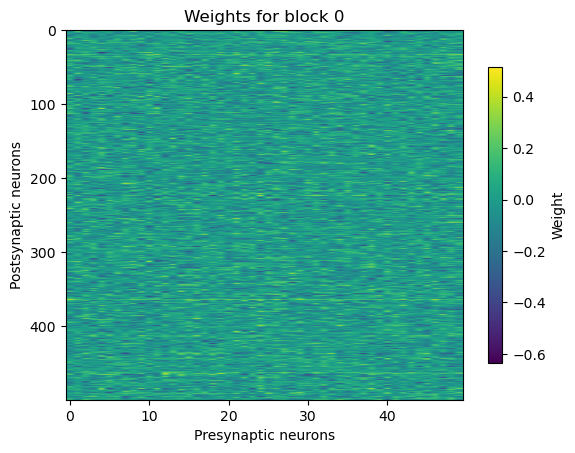

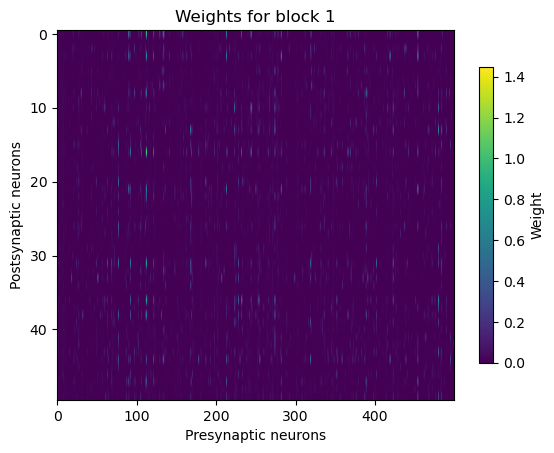

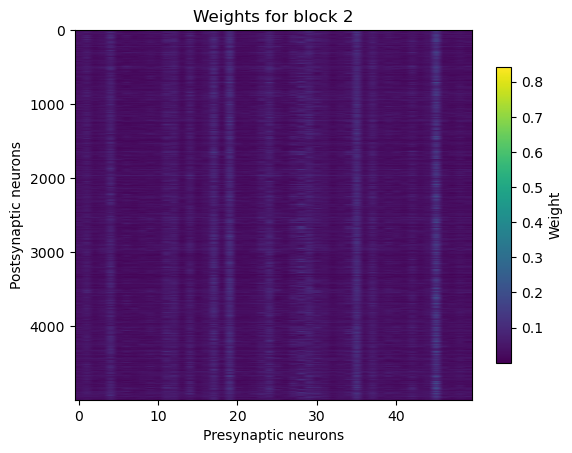

In [41]:
for i in range(len(layer_sizes)-1):
    hybrid_network.plot_weights(i)

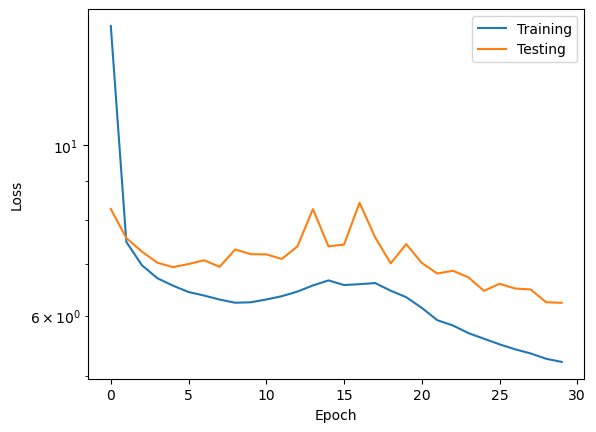

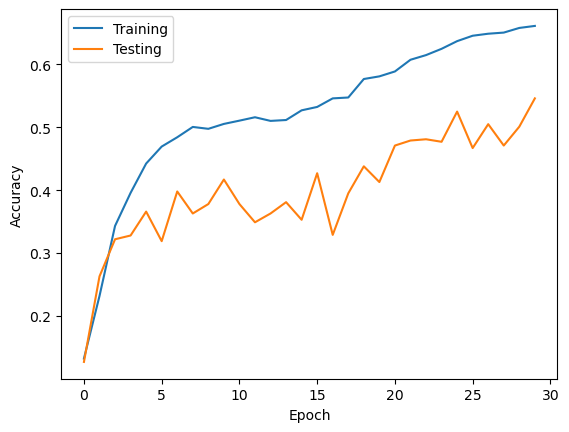

In [42]:
stats.plot(path=trained_folder+ "/")

## Inference with trained weights

In [31]:
# Loading the model
hybrid_network = HybridNetwork(
    layer_sizes, n_class, stdp_learning_rate, 
    stdp_tau_combined, train_hybrid=False, burn_in=50).to(device)

# SPECIFY THE EXACT NETWORK HERE.
hybrid_network.load_state_dict(torch.load(trained_folder + '/network.pt'))

# Retrieving one batch of testing examples
data, label = next(iter(testing_loader))
# Passing through the network and getting the readout of the last layer only
with torch.no_grad():
    readouts, _ = assistant.test(data, (one_hot(label.to(torch.int64), num_classes=n_class)))

# Softmaxing to get a probability distribution over all possible classes at 
# each timepoint, then finding the index of the largest probability value 
# for each timepoint, then finding the mode of these indices across all timepoints
values, _ = torch.mode(\
                torch.argmax(\
                    torch.nn.functional.softmax(\
                        readouts, dim=1), dim=1), dim=1)

print('Predictions:')
print(values.tolist()[0:20])
print('Ground truths')
print(label.tolist()[0:20])

Predictions:
[1, 0, 8, 8, 8, 1, 6, 5, 8, 0, 1, 1, 1, 8, 1, 3, 1, 1, 0, 8]
Ground truths
[5, 1, 8, 2, 6, 1, 4, 2, 7, 5, 2, 1, 1, 8, 5, 9, 3, 1, 4, 8]
